In [1]:
import pandas as pd
import re
from pathlib import Path
import pyarabic.araby as ar
from tqdm.notebook import tqdm
from sklearn.utils import shuffle

In [64]:
class Config:
    raw_data_file = 'tweets.csv'
    processed_data_file = 'tweets.csv'
    
    RAW_DATA_PATH = Path('../../data/raw')
    PROCESSED_DATA_PATH = Path('../../data/processed')
    
    RAW_DATA_FILE = RAW_DATA_PATH / raw_data_file
    PROCESSED_DATA_FILE = PROCESSED_DATA_PATH / processed_data_file
    
    MODEL_PATH = Path('../../model/lyrics/model')
    
    PLOT_PATH = Path('../../plots')
    PLOT_HEAT_MAP_FILE = PLOT_PATH / Path('heatmap.png')

In [3]:
SEED = 42

In [4]:
processed_data = pd.read_csv(Config.PROCESSED_DATA_FILE, index_col=False)

In [5]:
processed_data.head()

,ID,Tweet,Class
0,295820374774513667,رودجرز انا مستاء من لاعبينا الشباب حولنا منحهم...,anger
1,353619287652581376,من شفت انا عيونه اعلنت انا جنوني,anger
2,888346524714979329,أتفق انا عصبي وقاسي وعنيد ومتناقض ومزاجي وكتوم...,anger
3,870974517983752193,على فكرة انا مستاء جدا من تجربتي في محلكم في ا...,anger
4,886636321342619653,ع قد ما انا عصبي ع قد ما ابسط كلمه حلوه هتنسين...,anger


In [6]:
data = processed_data[processed_data['Class'].apply(lambda Class: Class in ['happiness', 'sadness', 'anger'])]
data = shuffle(data)
data.reset_index(drop=True, inplace=True)

In [7]:
data.head()

,ID,Tweet,Class
0,885478835881246720,انا مالا عرفت حيات او انا حزين,sadness
1,619998693043769344,إيفونا عبر الإنستجرام إلي القاهرة أنا سعيد للغاية,happiness
2,461191025126809600,فيه ناس لما يتكلمون معك ودك تقولهم معليش انا م...,happiness
3,547031715722444800,انا سعيد جدا انى حشوف القمر فى الصباح انت ب تن...,happiness
4,675891866555039745,يازين الاجازه وانت تشوف ناس رايحه للدوام وانت ...,happiness


In [8]:
data['Class'].value_counts()

happiness    22788
sadness      12906
anger         1154
Name: Class, dtype: int64

In [9]:
import tensorflow as tf
import tensorflow_addons as tfa

In [10]:
from sklearn.model_selection import train_test_split
import numpy as np

In [11]:
X = np.array(list(data['Tweet'])).astype(str)
y = np.array(list(data['Class'])).astype(str)

In [12]:
X.dtype

dtype('<U140')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED)

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
label_encoder = LabelEncoder()

In [16]:
label_encoder.fit(y_train)

LabelEncoder()

In [17]:
label_encoder.classes_

array(['anger', 'happiness', 'sadness'], dtype='<U9')

In [18]:
class_num = len(label_encoder.classes_)

In [19]:
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [20]:
y_train = tf.keras.utils.to_categorical(y_train, class_num)
y_test = tf.keras.utils.to_categorical(y_test, class_num)

In [21]:
VOCAB_SIZE = 10000

In [22]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE
)

In [23]:
encoder.adapt(X_train)

In [24]:
vocab = np.array(encoder.get_vocabulary())

In [25]:
vocab[0].decode('UTF-8')

'انا'

In [26]:
vocab = np.array(encoder.get_vocabulary())

In [27]:
vocab_utf8 = [word.decode('UTF-8') for word in vocab]

In [28]:
tf.keras.backend.clear_session()

In [29]:
def create_model():
    model = tf.keras.Sequential()
    
    model.add(encoder)
    
    model.add(
        tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE+1,
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)
    )
    
    model.add(
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
    )
    
    model.add(
        tf.keras.layers.Dense(64, activation='relu')
    )
    
    model.add(
        tf.keras.layers.Dense(class_num)
    )
    return model

In [30]:
model = create_model()

In [31]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=[tfa.metrics.F1Score(class_num)]
)

In [32]:
X_train.shape

(24688,)

In [33]:
y_train.shape

(24688, 3)

In [34]:
model_check_point_cb = tf.keras.callbacks.ModelCheckpoint(filepath=str(Config.MODEL_PATH),
                                                   monitor='val_f1_score',
                                                   save_weights_only=True)

In [35]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[model_check_point_cb])

Train on 19750 samples, validate on 4938 samples
Epoch 1/10
19750/19750 [==============================] - 33s 2ms/sample - loss: 0.5277 - f1_score: 0.5170 - val_loss: 0.1603 - val_f1_score: 0.6464
Epoch 2/10
19750/19750 [==============================] - 17s 857us/sample - loss: 0.1053 - f1_score: 0.6496 - val_loss: 0.0894 - val_f1_score: 0.6573
Epoch 3/10
19750/19750 [==============================] - 23s 1ms/sample - loss: 0.0516 - f1_score: 0.8813 - val_loss: 0.0601 - val_f1_score: 0.9111
Epoch 4/10
19750/19750 [==============================] - 17s 872us/sample - loss: 0.0261 - f1_score: 0.9789 - val_loss: 0.0547 - val_f1_score: 0.9366
Epoch 5/10
19750/19750 [==============================] - 17s 864us/sample - loss: 0.0140 - f1_score: 0.9930 - val_loss: 0.0702 - val_f1_score: 0.9378
Epoch 6/10
19750/19750 [==============================] - 24s 1ms/sample - loss: 0.0086 - f1_score: 0.9955 - val_loss: 0.0497 - val_f1_score: 0.9533
Epoch 7/10
19750/19750 [===========================

In [59]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [67]:
def evaluate():
    Config.PLOT_PATH.mkdir(parents=True, exist_ok=True)
    predictions = model.predict(X_test)
    
    y_pred = predictions.argmax(axis=1)
    y_true = y_test.argmax(axis=1)
    
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    
    plt.title('Classification Report')
    plt.legend([])
    sns.heatmap(df, annot=True, vmin=0, vmax=1, linewidths=.5)
    plt.savefig(str(Config.PLOT_HEAT_MAP_FILE))
    plt.show()
    plt.clf()

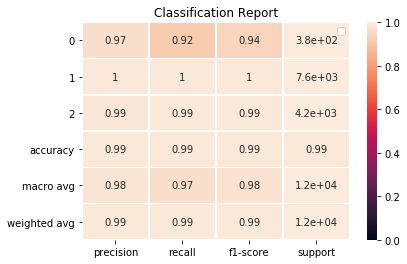

<Figure size 432x288 with 0 Axes>

In [68]:
evaluate()